In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/identifikasi-telur-rebus-and-telur-goreng/test/Sampel Telur Goreng/Picture136.png
/kaggle/input/identifikasi-telur-rebus-and-telur-goreng/test/Sampel Telur Goreng/Picture167.png
/kaggle/input/identifikasi-telur-rebus-and-telur-goreng/test/Sampel Telur Goreng/Picture40.png
/kaggle/input/identifikasi-telur-rebus-and-telur-goreng/test/Sampel Telur Goreng/Picture152.png
/kaggle/input/identifikasi-telur-rebus-and-telur-goreng/test/Sampel Telur Goreng/Picture198.jpg
/kaggle/input/identifikasi-telur-rebus-and-telur-goreng/test/Sampel Telur Goreng/Picture11.png
/kaggle/input/identifikasi-telur-rebus-and-telur-goreng/test/Sampel Telur Goreng/Picture31.jpg
/kaggle/input/identifikasi-telur-rebus-and-telur-goreng/test/Sampel Telur Goreng/Picture131.png
/kaggle/input/identifikasi-telur-rebus-and-telur-goreng/test/Sampel Telur Goreng/Picture92.png
/kaggle/input/identifikasi-telur-rebus-and-telur-goreng/test/Sampel Telur Goreng/Picture113.png
/kaggle/input/identifikasi-telur-rebus-and-t

Validation Accuracy: 0.8666666666666667
                     precision    recall  f1-score   support

Sampel Telur Goreng       0.83      1.00      0.91        10
 Sampel Telur Rebus       1.00      0.60      0.75         5

           accuracy                           0.87        15
          macro avg       0.92      0.80      0.83        15
       weighted avg       0.89      0.87      0.86        15

Test Accuracy: 0.972972972972973
                     precision    recall  f1-score   support

Sampel Telur Goreng       0.96      1.00      0.98        44
 Sampel Telur Rebus       1.00      0.93      0.97        30

           accuracy                           0.97        74
          macro avg       0.98      0.97      0.97        74
       weighted avg       0.97      0.97      0.97        74



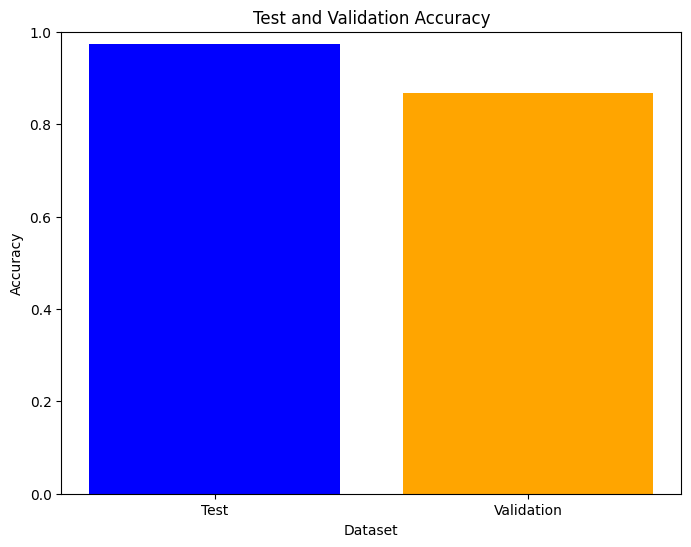

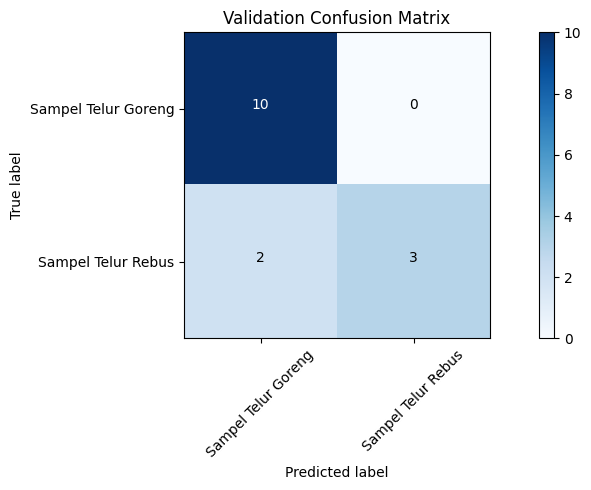

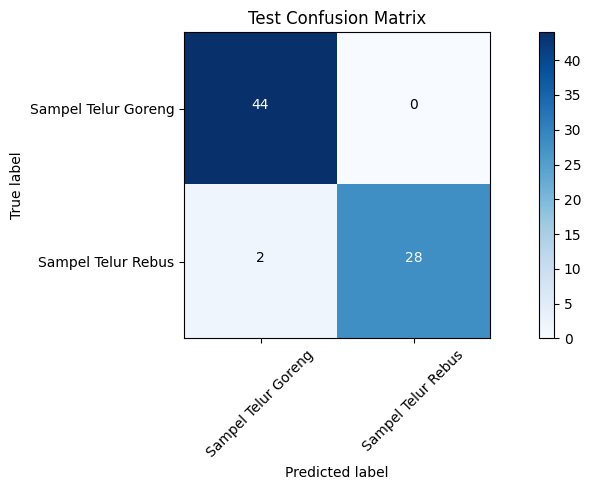

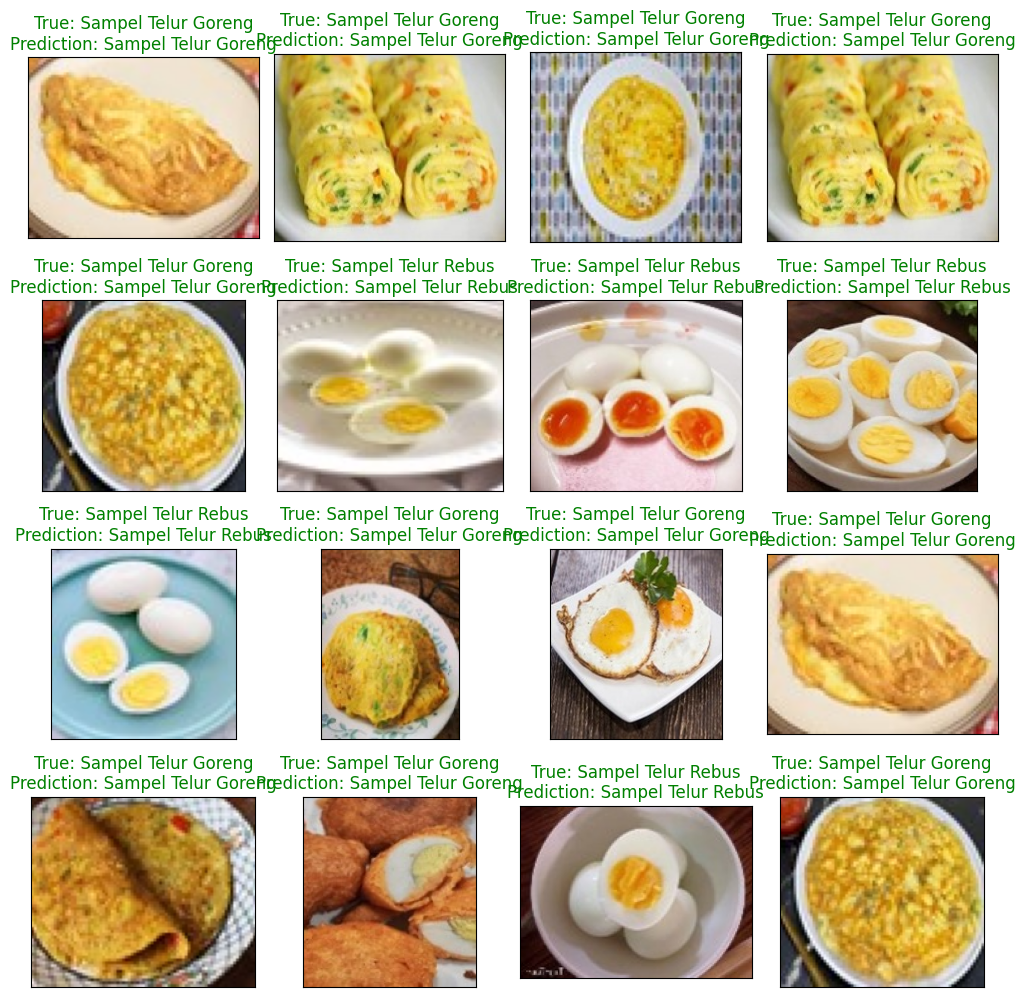

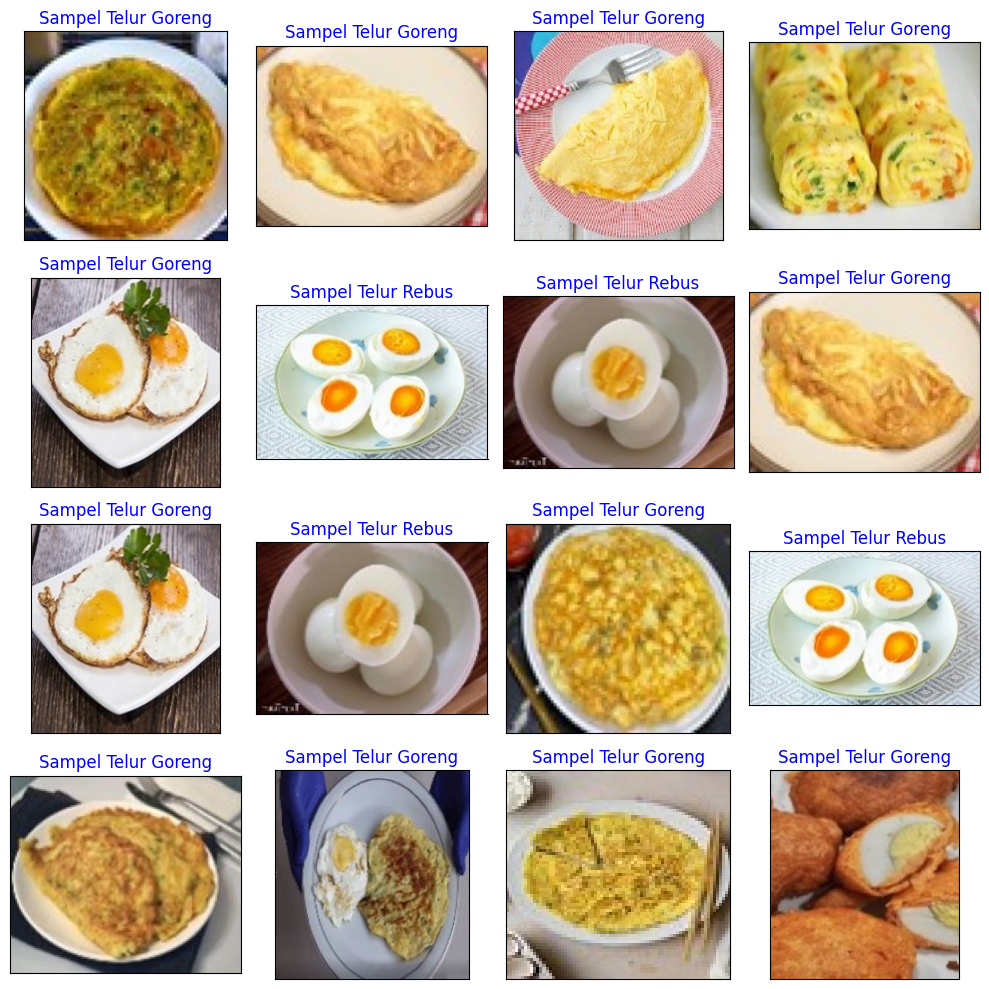

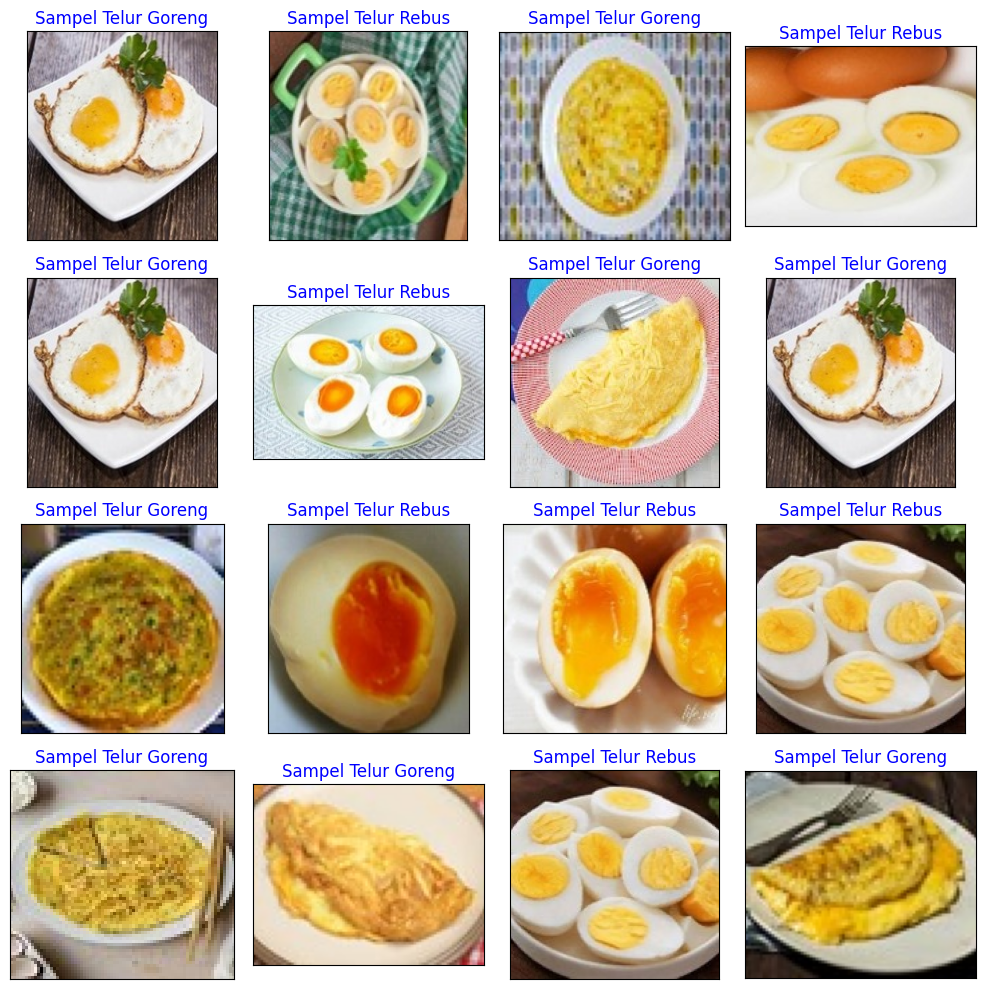

In [13]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import itertools

data_train = "/kaggle/input/identifikasi-telur-rebus-and-telur-goreng/train"
data_test = "/kaggle/input/identifikasi-telur-rebus-and-telur-goreng/test"

def convert_df(dataset):
    img_dir = Path(dataset)
    filenames = list(img_dir.glob('**/*.jpg'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filenames))
    if len(filenames) == 0:
        raise ValueError(f"No images found in the directory {dataset}")
    filenames = pd.Series(filenames, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    image_df = pd.concat([filenames, labels], axis=1)
    return image_df

image_train = convert_df(data_train)
image_test = convert_df(data_test)

def extract_hog_features(image_paths, img_size=(128, 128)):
    hog_features = []
    for img_path in image_paths:
        image = imread(img_path)
        image_resized = resize(image, img_size)  # Resize image
        image_gray = rgb2gray(image_resized)
        features = hog(image_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
        hog_features.append(features)
    if len(hog_features) == 0:
        raise ValueError("No HOG features extracted. Check if the images are being loaded correctly.")
    return np.array(hog_features)

X_train_hog = extract_hog_features(image_train['Filepath'])
X_test_hog = extract_hog_features(image_test['Filepath'])

y_train = image_train['Label']
y_test = image_test['Label']

# Split the training data into training and validation sets
X_train_hog, X_val_hog, y_train, y_val = train_test_split(X_train_hog, y_train, test_size=0.2, random_state=42)

# Train the Naive Bayes classifier
nb_model = GaussianNB()
nb_model.fit(X_train_hog, y_train)

# Evaluate the model on the validation set
y_val_pred = nb_model.predict(X_val_hog)
val_accuracy = accuracy_score(y_val, y_val_pred)
print('Validation Accuracy:', val_accuracy)
print(classification_report(y_val, y_val_pred, zero_division=1))

# Evaluate the model on the test set
y_test_pred = nb_model.predict(X_test_hog)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('Test Accuracy:', test_accuracy)
print(classification_report(y_test, y_test_pred, zero_division=1))

# Plotting the accuracies as a bar plot
accuracies = [test_accuracy, val_accuracy]
labels = ['Test', 'Validation']

plt.figure(figsize=(8, 6))
plt.bar(labels, accuracies, color=['blue', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Test and Validation Accuracy')
plt.ylim(0, 1)
plt.show()

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix for validation set
val_cm = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix for validation set
plt.figure(figsize=(10, 5))
plot_confusion_matrix(val_cm, classes=image_train['Label'].unique(), title='Validation Confusion Matrix')
plt.show()

# Plot confusion matrix for test set
test_cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 5))
plot_confusion_matrix(test_cm, classes=image_test['Label'].unique(), title='Test Confusion Matrix')
plt.show()

# Visualize some predictions
random_index = np.random.randint(0, len(image_test), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = imread(image_test['Filepath'].iloc[random_index[i]])
    ax.imshow(img)
    true_label = image_test['Label'].iloc[random_index[i]]
    pred_label = y_test_pred[random_index[i]]
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f'True: {true_label}\nPrediction: {pred_label}', color=color)

plt.tight_layout()
plt.show()

# Visualize some images from the training set
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
random_index_train = np.random.randint(0, len(image_train), 16)

for i, ax in enumerate(axes.flat):
    img = imread(image_train['Filepath'].iloc[random_index_train[i]])
    ax.imshow(img)
    label = image_train['Label'].iloc[random_index_train[i]]
    ax.set_title(f'{label}', color='blue')

plt.tight_layout()
plt.show()

# Visualize some images from the test set
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
random_index_test = np.random.randint(0, len(image_test), 16)

for i, ax in enumerate(axes.flat):
    img = imread(image_test['Filepath'].iloc[random_index_test[i]])
    ax.imshow(img)
    label = image_test['Label'].iloc[random_index_test[i]]
    ax.set_title(f'{label}', color='blue')

plt.tight_layout()
plt.show()
